# ***Распознавание текстов, сгенерированных Chat-GPT***


В рамках IT-трека Академии научного наставничества ставится задача создания модели для распознавание сгенерированных Chat-GPT текстов.

Доступно соревнование на [kaggle](https://www.kaggle.com/competitions/chat-gpt-generated-text-detection).

## Считывание данных

Для удобства будем загружать данные с гугл-диска

In [88]:
from google.colab import drive
drive.mount('/content/gdrive')

path="/content/gdrive/MyDrive/Академия научного наставничества IT/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [89]:
import pandas as pd
import numpy as np

train=pd.read_csv(path+"train.csv")
train

,id,text,author
0,3161,A new service called Twitter Alerts has been a...,chatgpt
1,24964,Swansea City fans will be delighted to hear th...,chatgpt
2,22861,Ready to go: Ross McCormack took part in Fulha...,person
3,68204,Penn Station is the busiest transportation hub...,chatgpt
4,10289,"The government, which had been the guarantor o...",chatgpt
...,...,...,...
84595,73004,"The cone-shaped machine, decelerated by a sequ...",chatgpt
84596,42153,CNN Student News offers a unique opportunity f...,chatgpt
84597,25941,"Cornelius Jefferson, a 33-year-old resident of...",chatgpt
84598,37518,Europe is experiencing a growing tendency away...,chatgpt


In [90]:
test=pd.read_csv(path+"test.csv")
test

,id,text
0,68113,There have been 50 online bomb threats made si...
1,19660,"Haifa Port, situated on the Mediterranean coas..."
2,79151,Connecticut Senator Richard Blumenthal had a s...
3,8415,Ohio's governor on Friday signed an executive ...
4,12307,"Kadaram was not the only target of the attack,..."
...,...,...
9394,84010,It's likely someone from Hong Kong has just be...
9395,241,"Calvin Veltman undertook, for the National Cen..."
9396,24258,I was so paranoid I might find a lump that I e...
9397,26109,"By . Laura Powell . PUBLISHED: . 16:13 EST, 3 ..."


## Исследование данных

**Проверим баланс классов**

В задаче классификации данные называются несбалансированными (Imbalanced Data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы».

<BarContainer object of 2 artists>

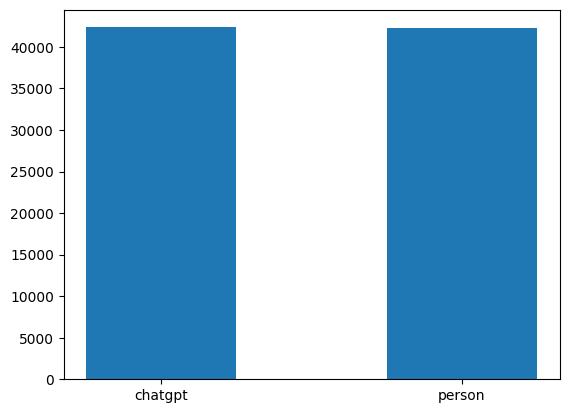

In [91]:
import matplotlib.pyplot as plt

groups = ["chatgpt", "person"]
counts = [len(train.loc[train["author"]=="chatgpt"]), len(train.loc[train["author"]=="person"])]

plt.bar(groups, counts, width=0.5)

Рассмотрим распределение текстов по количеству предложений. Подобная информация о данных также может быть использована для классификации.

<Axes: >

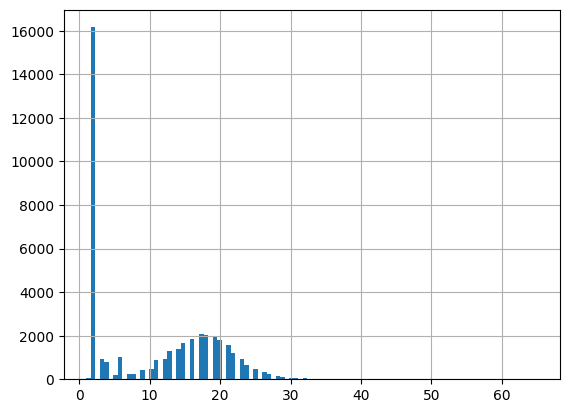

In [92]:
seq_len = [len(str(i).split(".")) for i in train.loc[train["author"]=="chatgpt"]["text"]]
pd.Series(seq_len).hist(bins = 100)

<Axes: >

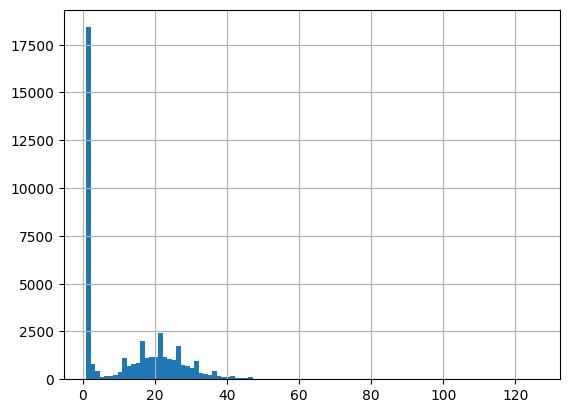

In [93]:
seq_len = [len(str(i).split(".")) for i in train.loc[train["author"]=="person"]["text"]]
pd.Series(seq_len).hist(bins = 100)

Добавим информацию о числе предложений в наш DataFrame

In [94]:
seq_len = [len(str(i).split(".")) for i in train["text"]]
train.loc[:, "points"] = seq_len

seq_len = [len(str(i).split(".")) for i in test["text"]]
test.loc[:, "points"] = seq_len

Количество слов в текстах

<Axes: >

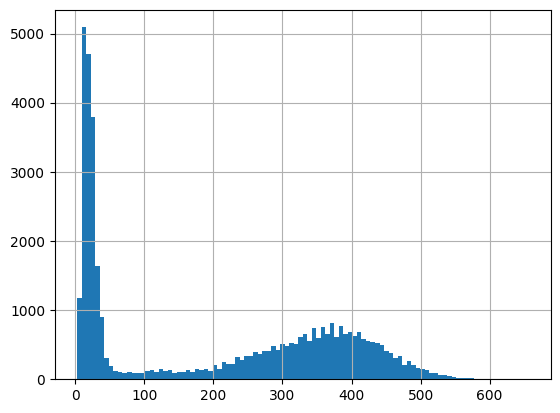

In [95]:
seq_len = [len(str(i).split()) for i in train.loc[train["author"]=="chatgpt"]["text"]]
pd.Series(seq_len).hist(bins = 100)

<Axes: >

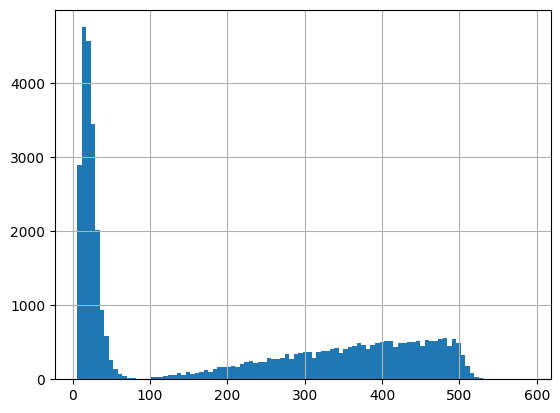

In [96]:
seq_len = [len(str(i).split()) for i in train.loc[train["author"]=="person"]["text"]]
pd.Series(seq_len).hist(bins = 100)

In [97]:
seq_len = [len(str(i).split()) for i in train["text"]]
train.loc[:, "words"] = seq_len

seq_len = [len(str(i).split()) for i in test["text"]]
test.loc[:, "words"] = seq_len

Попробуем убрать из выборки, используемой для обучения, тексты, в которых количество текстов менее 500. (OpenAI публиковал информацию о том, что возникают сложности с распознаванием коротких (менее 1000 символов) текстов)

In [98]:
l = [len(i) for i in train["text"]]
train.loc[:, "l"] = l
train=train.loc[train["l"]>=500]
train=train.dropna()
train=train.drop(columns=["l"])

<Axes: >

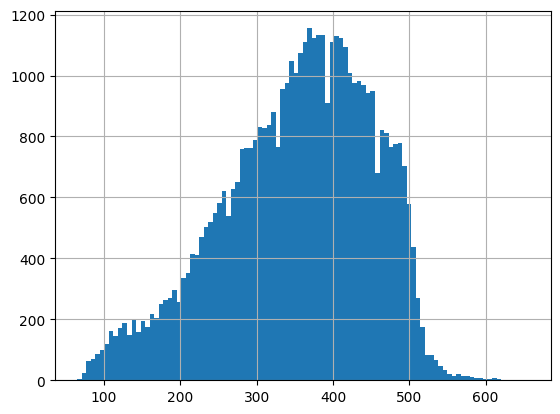

In [99]:
seq_len = [len(str(i).split()) for i in train["text"]]
pd.Series(seq_len).hist(bins = 100)

In [100]:
train

,id,text,author,points,words
0,3161,A new service called Twitter Alerts has been a...,chatgpt,12,232
1,24964,Swansea City fans will be delighted to hear th...,chatgpt,14,280
9,181,Police have seized yet another supercar after ...,person,15,297
10,31285,An elderly woman has tragically died after an ...,chatgpt,23,375
14,23041,Former West Ham and Watford boss Gianfranco Zo...,person,11,243
...,...,...,...,...,...
84587,71008,The South West Trains-Network Rail Alliance sp...,chatgpt,6,163
84588,76818,"Shares of Facebook, one of the world's largest...",chatgpt,23,523
84589,50877,"In a surprising turn of events, a union organi...",chatgpt,16,382
84596,42153,CNN Student News offers a unique opportunity f...,chatgpt,10,231


In [101]:
train.loc[train["author"]=="chatgpt", 'author']=0
train.loc[train["author"]=="person", 'author']=1
train

,id,text,author,points,words
0,3161,A new service called Twitter Alerts has been a...,0,12,232
1,24964,Swansea City fans will be delighted to hear th...,0,14,280
9,181,Police have seized yet another supercar after ...,1,15,297
10,31285,An elderly woman has tragically died after an ...,0,23,375
14,23041,Former West Ham and Watford boss Gianfranco Zo...,1,11,243
...,...,...,...,...,...
84587,71008,The South West Trains-Network Rail Alliance sp...,0,6,163
84588,76818,"Shares of Facebook, one of the world's largest...",0,23,523
84589,50877,"In a surprising turn of events, a union organi...",0,16,382
84596,42153,CNN Student News offers a unique opportunity f...,0,10,231


При работе с текстами знаки препинания обычно удаляются, чтобы немного "очистить" данные.

In [76]:
punctuation_signs = list("?:!.,;")
for punct_sign in punctuation_signs:
    train['text'] = train['text'].str.replace(punct_sign, '')
    test['text'] = test['text'].str.replace(punct_sign, '')

<ipython-input-76-03ad3a5b4729>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['text'] = train['text'].str.replace(punct_sign, '')
<ipython-input-76-03ad3a5b4729>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['text'] = test['text'].str.replace(punct_sign, '')


Помимо удаления знаков препинания часто используется исключение всех неалфавитных символов

In [102]:
import re

def del_s(df, col):
    text_list = []
    for row in range(len(df)):
        lemmatized_list = []
        text = df.iloc[row][col]
        text=re.sub("[^a-zA-Z]"," ",text)
        text_list.append(text)
    return text_list
train["text"]=del_s(train, "text")
test["text"]=del_s(test, "text")

## Эмбеддинги

Векторное представление слов (англ. word embedding) — общее название для различных подходов к моделированию языка и обучению представлений в обработке естественного языка, направленных на сопоставление словам из некоторого словаря векторов небольшой размерности.

**Перемешаем данные**

Это не так важно для обучения, а делается с целью оставить часть данных на тестирование и оценки точности решения задачи перед отправкой решения на kaggle

In [103]:
from sklearn.utils import shuffle
train = shuffle(train)
train

,id,text,author,points,words
45948,87307,By Mark Prigg Doctors have been warned to ...,1,23,429
27038,1137,CNN A winter storm ramping up in the Great Pl...,1,17,276
57641,13263,Renowned TV chef Jamie Oliver has come out t...,0,17,470
6071,10678,A ground crew worker at Dubai International Ai...,0,23,507
27762,40833,An incredible collection of rare aviation and...,0,16,346
...,...,...,...,...,...
79439,29958,A fire stoked by strong winds swept through a ...,1,25,429
7717,2688,A leisurely bike ride through Morgan Park in W...,0,19,361
57303,91873,Flooding in the region has been devastating w...,0,19,352
83293,55299,By Daily Mail Reporter A group of young th...,1,16,292


***Токенизация*** - метод позволяющий разделить текст на так называемые токены, то есть на слова или предложения.

***Лемматизация*** - приведение словоформы к лемме — ее нормальной (словарной) форме. Другими словами, лемматизация схожа с выделением основы каждого слова в предложении. Она обычно выполняется простым поиском форм в таблице.

***Стемминг*** - это процесс обрезания конца или начала слов с целью удаления аффиксов (лексических дополнений к корню слова).

***Векторизация текста*** - преобразование текста в численную форму. Алгоритмы машинного обучения не умеют работать с текстом, поэтому необходимо превратить текст в цифры.

In [104]:
import nltk
import re

nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [105]:
from nltk.corpus import stopwords
stop_=stopwords.words('english')
def func(df, col):
    wordnet_lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_text_list = []
    for row in range(len(df)):
        lemmatized_list = []
        text = df.iloc[row][col]
        text_words = text.split(" ")
        for word in text_words:
            word_norm = wordnet_lemmatizer.lemmatize(word)
            if word_norm not in stop_:
              lemmatized_list.append(word_norm)
        lemmatized_text_list.append(lemmatized_list)
    return lemmatized_text_list


train["text"] = func(train, "text")
test["text"] = func(test, "text")

In [81]:
from nltk.corpus import stopwords
stop_=stopwords.words('english')
def func(df, col):
    wordnet_lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_text_list = []
    for row in range(len(df)):
        lemmatized_list = []
        text = df.iloc[row][col]
        text_words = text.split(" ")
        for word in text_words:
            word_norm = wordnet_lemmatizer.lemmatize(word)
            if word_norm not in stop_:
              lemmatized_list.append(word_norm)
        lemmatized_text = " ".join(lemmatized_list)
        lemmatized_text_list.append(lemmatized_text)
    return lemmatized_text_list


train["text"] = func(train, "text")
test["text"] = func(test, "text")

In [106]:
all_data=pd.concat([train, test])

### Word2Vec

Word2Vec - один из самых популярных методов векторизации текстов, позволяющий учитывать контекст. Алгоритм основан основан на важной гипотезе, которую в науке принято называть гипотезой локальности — “слова, которые встречаются в одинаковых окружениях, имеют близкие значения”.

Одним из главных достоинств Word2Vec является то, что данный алгоритм позволяет при работе с текстами учитывать контекст.

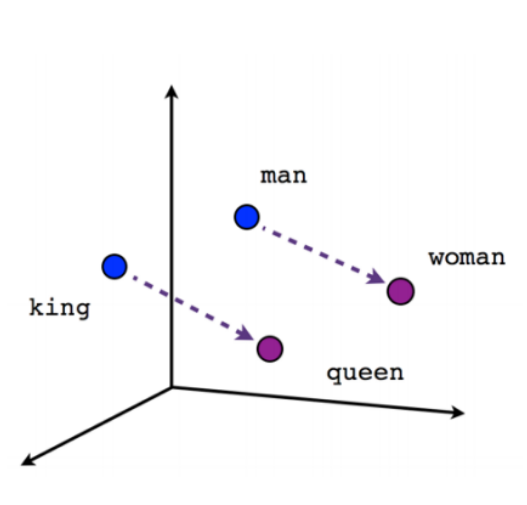

In [107]:
from gensim.models import word2vec

model = word2vec.Word2Vec(all_data["text"], vector_size=5000)
#создадим словарь со словами и соответсвующими им векторами
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

Каждое слово - вектор, а текст - среднее векторов, соответствутющих словам

In [109]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [110]:
train_matrix=mean_vectorizer(w2v).fit(train['text']).transform(train['text'])
train_matrix.shape

(46691, 5000)

In [111]:
test_matrix=mean_vectorizer(w2v).fit(test['text']).transform(test['text'])


In [98]:
train_matrix[0]

array([-2.39905164e-01, -1.00564514e-03, -1.83475897e-01,  2.80895326e-02,
        2.45257601e-01, -1.36635979e-04, -3.57085258e-01, -1.65278718e-01,
        1.07301353e-02,  3.07525963e-01, -5.75350486e-02, -9.60247219e-02,
        2.97889024e-01, -2.49187008e-01, -4.74895597e-01, -9.22150686e-02,
        4.11738545e-01, -4.11471397e-01,  8.37790519e-02,  4.77901310e-01,
       -4.04970288e-01, -1.68944612e-01,  3.86234909e-01,  1.89651698e-01,
       -5.76627180e-02, -1.39559984e-01, -1.58551455e-01, -1.15564100e-01,
       -1.85619712e-01, -1.72503531e-01, -1.93932429e-02,  2.51593947e-01,
        1.49521083e-01,  5.14469624e-01,  1.76102340e-01,  1.89247683e-01,
        1.62965417e-01,  1.22063681e-02, -2.28805356e-02,  2.47994781e-01,
       -2.46036559e-01,  4.40039158e-01,  5.36300875e-02, -1.82622701e-01,
       -1.60404325e-01, -1.52027100e-01, -4.90703322e-02,  1.41546614e-02,
       -4.67076987e-01,  1.52774677e-01, -2.70341802e-02,  3.20091546e-02,
       -5.19320607e-01,  

### FastText

FastText является расширением Word2Vec, предложенным Facebook в 2016 году. Вместо подачи отдельных слов в нейронную сеть, FastText разбивает слова на несколько n-граммов (подслов).

In [108]:
from gensim.models.fasttext import FastText

model=FastText(all_data["text"].to_numpy(), vector_size=100)
model.wv['artificial']

array([ 0.47414255,  1.7352964 ,  2.5067801 , -0.5724599 , -1.4768448 ,
       -0.66824514,  0.270424  , -0.25999266, -0.23250087, -0.36301544,
        0.00859721,  0.31828618,  1.473804  , -3.437109  ,  0.6204538 ,
        0.23396426,  0.6635041 , -0.79382867,  0.16315776,  1.8335776 ,
        1.8717983 ,  1.8172306 ,  0.5493006 ,  2.2241743 ,  0.44544482,
        1.591814  , -0.05853394, -1.3190428 , -0.34725976,  2.0579543 ,
        0.30855268,  0.38732448, -0.08956233, -0.26396137,  0.44909623,
       -2.5448093 , -0.37418872, -0.4371333 , -0.09178323,  0.576041  ,
        0.5634752 , -0.9324439 , -1.366451  ,  1.2051786 ,  0.72595704,
        1.5498757 ,  0.60730785,  0.5276022 , -1.1288656 ,  0.5943681 ,
        1.1270213 , -0.20747474,  0.17522858, -0.1359034 ,  0.74942464,
        0.25350034, -0.59289277,  0.916556  , -0.26466516,  1.421012  ,
       -1.0288666 , -0.4737792 ,  1.6449972 , -1.7754345 ,  1.8035208 ,
        1.2487153 ,  0.51962847,  1.6330172 , -0.06957599,  1.04

Процедура сложения/усреднения векторов аналогична работе с Word2Vec

In [109]:
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

In [110]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
train_matrix=mean_vectorizer(w2v).fit(train['text']).transform(train['text'])
test_matrix=mean_vectorizer(w2v).fit(test['text']).transform(test['text'])

Модуль CountVectorizer преобразовывает входной текст в матрицу, значениями которой являются количества вхождения данного ключа(слова) в текст.

Получается, так называемый, "мешок слов".

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer( max_features = 100)
matrix = count.fit_transform(all_data["text"]).toarray()

Идея TfidfVectorizer аналогична CountVectorizer, но при этом учитывается ещё и непосрественную важность каждого слова.

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000)
matrix = tfidf.fit_transform(all_data["text"]).toarray()

Добавляем в каждый столбец информацию о количестве слов и предложений в тексте.

In [ ]:
for i in range(len(train)):
  np.append(matrix[i],train.iloc[i]["points"])
  np.append(matrix[i],train.iloc[i]["words"])
for i in range(len(test)):
  np.append(matrix[len(train)+i],test.iloc[i]["points"])
  np.append(matrix[len(train)+i],test.iloc[i]["words"])

## Обучение модели

Градиентный бустинг — это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений.

In [20]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.6 MB/s eta 0:00:00


In [21]:
from catboost import CatBoostClassifier
model=CatBoostClassifier(iterations=3000,learning_rate=0.1, model_size_reg=10000, task_type="GPU")
model.fit(X=matrix[:len(train)-5000], y=train["author"].to_numpy().astype('int')[:-5000])

0:	learn: 0.6442221	total: 51.8ms	remaining: 2m 35s
1:	learn: 0.6101853	total: 99.2ms	remaining: 2m 28s
2:	learn: 0.5841330	total: 143ms	remaining: 2m 22s
3:	learn: 0.5641951	total: 185ms	remaining: 2m 18s
4:	learn: 0.5458339	total: 226ms	remaining: 2m 15s
5:	learn: 0.5320187	total: 273ms	remaining: 2m 16s
6:	learn: 0.5179631	total: 317ms	remaining: 2m 15s
7:	learn: 0.5074861	total: 358ms	remaining: 2m 13s
8:	learn: 0.4986144	total: 401ms	remaining: 2m 13s
9:	learn: 0.4902046	total: 442ms	remaining: 2m 12s
10:	learn: 0.4841970	total: 486ms	remaining: 2m 12s
11:	learn: 0.4777275	total: 529ms	remaining: 2m 11s
12:	learn: 0.4730412	total: 572ms	remaining: 2m 11s
13:	learn: 0.4679417	total: 614ms	remaining: 2m 10s
14:	learn: 0.4635919	total: 657ms	remaining: 2m 10s
15:	learn: 0.4582201	total: 700ms	remaining: 2m 10s
16:	learn: 0.4546565	total: 740ms	remaining: 2m 9s
17:	learn: 0.4510853	total: 782ms	remaining: 2m 9s
18:	learn: 0.4479677	total: 833ms	remaining: 2m 10s
19:	learn: 0.4446972	t

Будем использовать логистическую регресиию.

Про другие алгоритмы классификаии в библиотеке sklearn можно прочитать [здесь](https://tproger.ru/translations/scikit-learn-in-python/), а также в [документации sklearn](https://scikit-learn.ru/category/supervised_learning/).

In [112]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
model=LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X=train_matrix[:len(train)], y=train["author"].to_numpy().astype('int'))

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X=train_matrix[:len(train)-5000], y=train["author"].to_numpy().astype('int')[:-5000])

GaussianNB()

Тестируем модель, на части данных, которые не были использованы для обучения и строим ConfusionMatrix

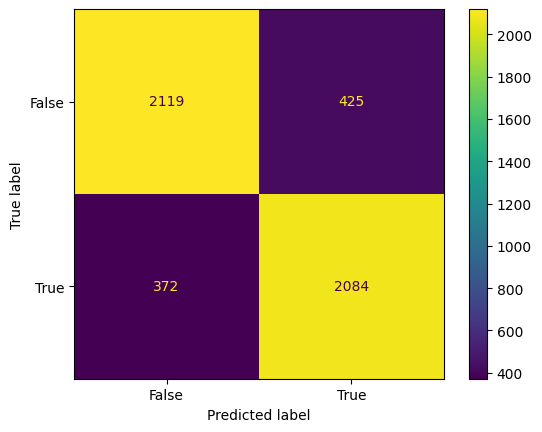

In [49]:
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred=model.predict(matrix[len(train)-5000:len(train)])
y_true=train["author"].to_numpy().astype('int')[-5000:]

confusion = confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [False, True])

cm_display.plot()
plt.show()

Считаем Accuracy и F1-score

In [50]:
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.f1_score(y_true, y_pred))

0.8406
0.8394763343403827


Готовим результат для отправки на kaggle

In [114]:
res=model.predict(test_matrix)

In [ ]:
output=test.drop(columns=["text"])
output.loc[:, "author"] = res
output

,id,points,words,author
0,68113,15,360,1
1,19660,6,164,1
2,79151,21,376,0
3,8415,20,450,1
4,12307,2,19,0
...,...,...,...,...
9394,84010,35,360,1
9395,241,2,28,1
9396,24258,2,16,1
9397,26109,27,388,1


In [115]:
output=test.drop(columns=["text","words","points"])
output.loc[:, "author"] = res
output

,id,author
0,68113,1
1,19660,1
2,79151,0
3,8415,1
4,12307,0
...,...,...
9394,84010,1
9395,241,1
9396,24258,1
9397,26109,1


In [116]:
from google.colab import files
output.to_csv("solution.csv", index=False)

files.download("solution.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>